# Talktorial 1

# Compound data acquisition (ChEMBL)

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Paula Junge and Svetlana Leng

## Aim of this talktorial

We learn how to extract data from ChEMBL:

* Find ligands which were tested on a certain target
* Filter by available bioactivity data
* Calculate pIC50 values
* Merge dataframes and draw extracted molecules

## Learning goals


### Theory

* ChEMBL database
    * ChEMBL web services
    * ChEMBL webresource client
* Compound activity measures
    * IC50
    * pIC50

### Practical
    
Goal: Get list of compounds with bioactivity data for a given target

* Connect to ChEMBL database
* Get target data (EGFR kinase)
* Bioactivity data
    * Download and filter bioactivities
    * Clean and convert
* Compound data
    * Get list of compounds
    * Prepare output data
* Output
    * Draw molecules with highest pIC50
    * Write output file


## References

* ChEMBL bioactivity database (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5210557/)
* ChEMBL web services: <i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620 (https://academic.oup.com/nar/article/43/W1/W612/2467881) 
* ChEMBL webrescource client GitHub (https://github.com/chembl/chembl_webresource_client)
* myChEMBL webservices version 2.x (https://github.com/chembl/mychembl/blob/master/ipython_notebooks/09_myChEMBL_web_services.ipynb)
* ChEMBL web-interface (https://www.ebi.ac.uk/chembl/)
* EBI-RDF platform (https://www.ncbi.nlm.nih.gov/pubmed/24413672)
* IC50 and pIC50 (https://en.wikipedia.org/wiki/IC50)
* UniProt website (https://www.uniprot.org/)

_____________________________________________________________________________________________________________________


## Theory

### ChEMBL database

* Open large-scale bioactivity database
* **Current data content (as of 10.2018):**
    * \>1.8 million distinct compound structures
    * \>15 million activity values from 1 million assays
    * Assays are mapped to ∼12 000 targets
* **Data sources** include scientific literature, PubChem bioassays, Drugs for Neglected Diseases Initiative (DNDi), BindingDB database, ...
* ChEMBL data can be accessed via a [web-interface](https://www.ebi.ac.uk/chembl/), the [EBI-RDF platform](https://www.ncbi.nlm.nih.gov/pubmed/24413672) and the [ChEMBL web services](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/#B5)
 
    
#### ChEMBL web services

* RESTful web service
* ChEMBL web service version 2.x resource schema: 

[![ChEMBL web service schema](images/chembl_webservices_schema_diagram.jpg)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/figure/F2/)

*Figure 1:* 
"ChEMBL web service schema diagram. The oval shapes represent ChEMBL web service resources and the line between two resources indicates that they share a common attribute. The arrow direction shows where the primary information about a resource type can be found. A dashed line indicates the relationship between two resources behaves differently. For example, the `Image` resource provides a graphical based representation of a `Molecule`."
Figure and description taken from: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881).


#### ChEMBL webresource client

* Python client library for accessing ChEMBL data
* Handles interaction with the HTTPS protocol
* Lazy evaluation of results -> reduced number of network requests

### Compound activity measures

#### IC50 

* [Half maximal inhibitory concentration](https://en.wikipedia.org/wiki/IC50)
* Indicates how much of a particular drug or other substance is needed to inhibit a given biological process by half

[<img src="https://upload.wikimedia.org/wikipedia/commons/8/81/Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png" width="450" align="center" >](https://commons.wikimedia.org/wiki/File:Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png)

*Figure 2:* Visual demonstration of how to derive an IC50 value: Arrange data with inhibition on vertical axis and log(concentration) on horizontal axis; then identify max and min inhibition; then the IC50 is the concentration at which the curve passes through the 50% inhibition level.

#### pIC50

* To facilitate the comparison of IC50 values, we define pIC50 values on a logarithmic scale, such that <br />
    $ pIC_{50} = -log_{10}(IC_{50}) $ where $ IC_{50}$ is specified in units of M.
* Higher pIC50 values indicate exponentially greater potency of the drug
* pIC50 is given in terms of molar concentration (mol/L or M) <br />
    * IC50 should be specified in M to convert to pIC50  
    * For nM: $pIC_{50} = -log_{10}(IC_{50}*10^{-9})= 9-log_{10}(IC_{50}) $
    
Besides, IC50 and pIC50, other bioactivity measures are used, such as the equilibrium constant [KI](https://en.wikipedia.org/wiki/Equilibrium_constant) and the half maximal effective concentration  [EC50](https://en.wikipedia.org/wiki/EC50).

## Practical

In the following, we want to download all molecules that have been tested against our target of interest, the EGFR kinase.

### Connect to ChEMBL database

First, the ChEMBL webresource client as well as other python libraries are imported.

In [1]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
import math
from rdkit.Chem import PandasTools

/home/dominique/anaconda3/envs/cadd-py36/lib/python3.6/site-packages/grequests.py:21: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.contrib.pyopenssl (/home/dominique/anaconda3/envs/cadd-py36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py)', 'urllib3.util (/home/dominique/anaconda3/envs/cadd-py36/lib/python3.6/site-packages/urllib3/util/__init__.py)']. 
  curious_george.patch_all(thread=False, select=False)


Create resource objects for API access.

In [2]:
targets = new_client.target
compounds = new_client.molecule
bioactivities = new_client.activity

## Target data

* Get UniProt-ID (http://www.uniprot.org/uniprot/P00533) of the target of interest (EGFR kinase) from UniProt website (https://www.uniprot.org/)
* Use UniProt-ID to get target information
* Select a different UniProt-ID if you are interested into another target

In [3]:
uniprot_id = 'P00533'
# Get target information from ChEMBL but restrict to specified values only
target_P00533 = targets.get(target_components__accession=uniprot_id) \
                       .only('target_chembl_id', 'organism', 'pref_name', 'target_type')
print(type(target_P00533))
pd.DataFrame.from_records(target_P00533)

<class 'chembl_webresource_client.query_set.QuerySet'>


,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
2,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HER1 and HER2),CHEMBL2111431,PROTEIN FAMILY
3,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
4,Homo sapiens,MER intracellular domain/EGFR extracellular domain chimera,CHEMBL3137284,CHIMERIC PROTEIN


### After checking the entries, we select the first entry as our target of interest
`CHEMBL203`: It is a single protein and represents the human Epidermal growth factor receptor (EGFR, also named erbB1) 

In [4]:
target = target_P00533[0]
target

{'organism': 'Homo sapiens',
 'pref_name': 'Epidermal growth factor receptor erbB1',
 'target_chembl_id': 'CHEMBL203',
 'target_type': 'SINGLE PROTEIN'}

Save selected ChEMBL-ID.

In [5]:
chembl_id = target['target_chembl_id']
chembl_id

'CHEMBL203'

### Bioactivity data

Now, we want to query bioactivity data for the target of interest.

#### Download and filter bioactivities for the target

In this step, we download and filter the bioactivity data and only consider

* human proteins
* bioactivity type IC50
* exact measurements (relation '=')    
* binding data (assay type 'B')

In [6]:
bioact = bioactivities.filter(target_chembl_id = chembl_id) \
                      .filter(type = 'IC50') \
                      .filter(relation = '=') \
                      .filter(assay_type = 'B') \
                      .only('activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
                            'molecule_chembl_id', 'type', 'units', 'relation', 'value', \
                            'target_chembl_id', 'target_organism')
len(bioact), len(bioact[0]), type(bioact), type(bioact[0])

(6440, 11, chembl_webresource_client.query_set.QuerySet, dict)

#### Clean and convert bioactivity data

The data is stored as a list of dictionaries

In [7]:
bioact[0]

{'activity_id': 32260,
 'assay_chembl_id': 'CHEMBL674637',
 'assay_description': 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL68920',
 'relation': '=',
 'target_chembl_id': 'CHEMBL203',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.041'}

Convert to pandas dataframe (this might take some minutes).

In [8]:
bioact_df = pd.DataFrame.from_records(bioact)
bioact_df.head(10)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,target_chembl_id,target_organism,type,units,value
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase,B,CHEMBL68920,=,CHEMBL203,Homo sapiens,IC50,uM,0.041
1,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase,B,CHEMBL68920,=,CHEMBL203,Homo sapiens,IC50,uM,0.041
2,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase,B,CHEMBL69960,=,CHEMBL203,Homo sapiens,IC50,uM,0.17
3,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor receptor tyrosine kinase isolated from A431 (human carcinoma).,B,CHEMBL137635,=,CHEMBL203,Homo sapiens,IC50,uM,9.3
4,32770,CHEMBL674643,Inhibitory concentration of EGF dependent autophosphorylation of epidermal growth factor receptor kinase,B,CHEMBL306988,=,CHEMBL203,Homo sapiens,IC50,uM,500
5,32772,CHEMBL674643,Inhibitory concentration of EGF dependent autophosphorylation of epidermal growth factor receptor kinase,B,CHEMBL66879,=,CHEMBL203,Homo sapiens,IC50,uM,3000
6,32780,CHEMBL674643,Inhibitory concentration of EGF dependent autophosphorylation of epidermal growth factor receptor kinase,B,CHEMBL77085,=,CHEMBL203,Homo sapiens,IC50,uM,96
7,33406,CHEMBL674637,Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase,B,CHEMBL443268,=,CHEMBL203,Homo sapiens,IC50,uM,5.31
8,34039,CHEMBL674643,Inhibitory concentration of EGF dependent autophosphorylation of epidermal growth factor receptor kinase,B,CHEMBL76979,=,CHEMBL203,Homo sapiens,IC50,uM,264
9,34041,CHEMBL674643,Inhibitory concentration of EGF dependent autophosphorylation of epidermal growth factor receptor kinase,B,CHEMBL76589,=,CHEMBL203,Homo sapiens,IC50,uM,0.125


In [9]:
bioact_df.shape

(6441, 11)

Delete entries with missing values.

In [10]:
bioact_df = bioact_df.dropna(axis=0, how = 'any')
bioact_df.shape

(6440, 11)

Delete duplicates:
Sometimes the same molecule (`molecule_chembl_id`) has been tested more than once, in this case, we only keep the first one.

In [11]:
bioact_df = bioact_df.drop_duplicates('molecule_chembl_id', keep = 'first')
bioact_df.shape

(4849, 11)

We would like to only keep bioactivity data measured in molar units. The following print statements will help us to see what units are contained and to control what is kept after dropping some rows.

In [12]:
print(bioact_df.units.unique())
bioact_df = bioact_df.drop(bioact_df.index[~bioact_df.units.str.contains('M')])
print(bioact_df.units.unique())
bioact_df.shape

['uM' 'nM' 'M' "10'1 ug/ml" 'ug ml-1' "10'-1microM" "10'1 uM" "10'-1 ug/ml"
 "10'-2 ug/ml" "10'2 uM" '/uM' "10'-6g/ml" 'mM' 'umol/L' 'nmol/L']
['uM' 'nM' 'M' "10'-1microM" "10'1 uM" "10'2 uM" '/uM' 'mM']


(4780, 11)

Since we deleted some rows, but we want to iterate over the index later, we reset index to be continuous.

In [13]:
bioact_df = bioact_df.reset_index(drop=True) 
bioact_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,target_chembl_id,target_organism,type,units,value
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase,B,CHEMBL68920,=,CHEMBL203,Homo sapiens,IC50,uM,0.041
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase,B,CHEMBL69960,=,CHEMBL203,Homo sapiens,IC50,uM,0.17
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor receptor tyrosine kinase isolated from A431 (human carcinoma).,B,CHEMBL137635,=,CHEMBL203,Homo sapiens,IC50,uM,9.3
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent autophosphorylation of epidermal growth factor receptor kinase,B,CHEMBL306988,=,CHEMBL203,Homo sapiens,IC50,uM,500
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent autophosphorylation of epidermal growth factor receptor kinase,B,CHEMBL66879,=,CHEMBL203,Homo sapiens,IC50,uM,3000


To allow further comparison of the IC50 values, we convert all units to nM. First, we write a helper function, which can be applied to the whole dataframe in the next step.

In [14]:
def convert_to_NM(unit, bioactivity):
#     c=0
# for i, unit in enumerate(bioact_df.units):
    if unit != "nM":         
        if unit == "10'-1microM":
            value = float(bioactivity)*100
        elif unit == "uM" or unit == "/uM":
            value = float(bioactivity)*1000
        elif unit == "10'1 uM":
            value = float(bioactivity)*10000 
        elif unit == "10'2 uM":
            value = float(bioactivity)*100000
        elif unit == "mM":
            value = float(bioactivity)*1000000
        elif unit == "M":
            value = float(bioactivity)*1000000000
        else:
            print ('unit not regonized...')
        return value
    else: return bioactivity

In [15]:
bioactivity_nM = []
for i, row in bioact_df.iterrows():
    bioact_nM = convert_to_NM(row['units'], row['value'])
    bioactivity_nM.append(bioact_nM)
bioact_df['value'] = bioactivity_nM
bioact_df['units'] = 'nM'
bioact_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,target_chembl_id,target_organism,type,units,value
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase,B,CHEMBL68920,=,CHEMBL203,Homo sapiens,IC50,nM,41
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase,B,CHEMBL69960,=,CHEMBL203,Homo sapiens,IC50,nM,170
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor receptor tyrosine kinase isolated from A431 (human carcinoma).,B,CHEMBL137635,=,CHEMBL203,Homo sapiens,IC50,nM,9300
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent autophosphorylation of epidermal growth factor receptor kinase,B,CHEMBL306988,=,CHEMBL203,Homo sapiens,IC50,nM,500000
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent autophosphorylation of epidermal growth factor receptor kinase,B,CHEMBL66879,=,CHEMBL203,Homo sapiens,IC50,nM,3e+06


### Compound data

We have a data frame containing all molecules tested (with the respective measure) against EGFR. Now, we want to get the molecules that are stored behind the respective ChEMBL IDs. 

#### Get list of compounds

Let's have a look at the compounds from ChEMBL we have defined bioactivity data for. First, we retrieve ChEMBL ID and structures for the compounds with desired bioactivity data.

In [16]:
cmpd_id_list = list(bioact_df['molecule_chembl_id'])
compound_list = compounds.filter(molecule_chembl_id__in = cmpd_id_list) \
                         .only('molecule_chembl_id','molecule_structures')

Then, we convert the list to a pandas dataframe and delete duplicates (again, the pandas from_records function might take some time).

In [17]:
compound_df = pd.DataFrame.from_records(compound_list)
compound_df = compound_df.drop_duplicates('molecule_chembl_id', keep = 'first')
print(compound_df.shape)
print(bioact_df.shape)
compound_df.head()

(4780, 2)
(4780, 11)


,molecule_chembl_id,molecule_structures
0,CHEMBL6246,"{'canonical_smiles': 'Oc1cc2C(=O)Oc3c(O)c(O)cc4C(=O)Oc(c1O)c2c34', 'standard_inchi': 'InChI=1S/C14H6O8/c15-5-1-3-7-8-4(14(20)22-11(7)9(5)17)2-6(16)10(18)12(8)21-13(3)19/h1-2,15-18H', 'standard_inchi_key': 'AFSDNFLWKVMVRB-UHFFFAOYSA-N'}"
2,CHEMBL10,"{'canonical_smiles': 'C[S+]([O-])c1ccc(cc1)c2nc(c3ccc(F)cc3)c([nH]2)c4ccncc4', 'standard_inchi': 'InChI=1S/C21H16FN3OS/c1-27(26)18-8-4-16(5-9-18)21-24-19(14-2-6-17(22)7-3-14)20(25-21)15-10-12-23-13-11-15/h2-13H,1H3,(H,24,25)', 'standard_inchi_key': 'CDMGBJANTYXAIV-UHFFFAOYSA-N'}"
3,CHEMBL6976,"{'canonical_smiles': 'COc1cc2CC3=C(Nc2cc1OC)N=CN(C)C3=O', 'standard_inchi': 'InChI=1S/C14H15N3O3/c1-17-7-15-13-9(14(17)18)4-8-5-11(19-2)12(20-3)6-10(8)16-13/h5-7,16H,4H2,1-3H3', 'standard_inchi_key': 'ZTVYMXRRHFGHRV-UHFFFAOYSA-N'}"
4,CHEMBL7002,"{'canonical_smiles': 'CC1(COc2ccc(CC3SC(=O)NC3=O)cc2)CCCCC1', 'standard_inchi': 'InChI=1S/C18H23NO3S/c1-18(9-3-2-4-10-18)12-22-14-7-5-13(6-8-14)11-15-16(20)19-17(21)23-15/h5-8,15H,2-4,9-12H2,1H3,(H,19,20,21)', 'standard_inchi_key': 'YZFWTZACSRHJQD-UHFFFAOYSA-N'}"
5,CHEMBL414013,"{'canonical_smiles': 'COc1cc2Cc3c(O)ncnc3Nc2cc1OC', 'standard_inchi': 'InChI=1S/C13H13N3O3/c1-18-10-4-7-3-8-12(14-6-15-13(8)17)16-9(7)5-11(10)19-2/h4-6H,3H2,1-2H3,(H2,14,15,16,17)', 'standard_inchi_key': 'NVPFAFOQUJRLJO-UHFFFAOYSA-N'}"


So far, we have multiple different molecular structure representations. We only want to keep the canonical SMILES.

In [18]:
for i, cmpd in compound_df.iterrows():
    if compound_df.loc[i]['molecule_structures'] != None:
        compound_df.loc[i]['molecule_structures'] = cmpd['molecule_structures']['canonical_smiles']

print (compound_df.shape)

(4780, 2)


#### Prepare output data

Merge values of interest in one dataframe on ChEMBL-IDs:
* ChEMBL-IDs
* SMILES
* units
* IC50

In [19]:
output_df = pd.merge(bioact_df[['molecule_chembl_id','units','value']], compound_df, on='molecule_chembl_id')
print(output_df.shape)
output_df.head()

(4780, 4)


,molecule_chembl_id,units,value,molecule_structures
0,CHEMBL68920,nM,41,Cc1cc(C)c(\C=C\2/C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c23)[nH]1
1,CHEMBL69960,nM,170,Cc1cc([nH]c1\C=C\2/C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c23)C(=O)N5CCOCC5
2,CHEMBL137635,nM,9300,CN(c1ccccc1)c2ncnc3ccc(NN=NCc4ccccn4)cc23
3,CHEMBL306988,nM,500000,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1
4,CHEMBL66879,nM,3e+06,OC(=O)\C=C\c1ccc(O)cc1


For distinct column names, we rename IC50 and SMILES columns.

In [20]:
output_df = output_df.rename(columns= {'molecule_structures':'smiles', 'value':'IC50'})
output_df.shape

(4780, 4)

If we do not have a SMILES representation of a compound, we can not further use it in the following talktorials. Therefore, we delete compounds without SMILES column.

In [21]:
output_df = output_df[~output_df['smiles'].isnull()]
print(output_df.shape)
output_df.head()

(4771, 4)


,molecule_chembl_id,units,IC50,smiles
0,CHEMBL68920,nM,41,Cc1cc(C)c(\C=C\2/C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c23)[nH]1
1,CHEMBL69960,nM,170,Cc1cc([nH]c1\C=C\2/C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c23)C(=O)N5CCOCC5
2,CHEMBL137635,nM,9300,CN(c1ccccc1)c2ncnc3ccc(NN=NCc4ccccn4)cc23
3,CHEMBL306988,nM,500000,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1
4,CHEMBL66879,nM,3e+06,OC(=O)\C=C\c1ccc(O)cc1


In the next cell, you see that the low IC50 values are difficult to read. Therefore, we prefer to convert the IC50 values to pIC50.

In [28]:
output_df = output_df.reset_index(drop=True)
ic50 = output_df.IC50.astype(float) 
print(len(ic50))
print(ic50.head(10))

4771
0         41.0
1        170.0
2       9300.0
3     500000.0
4    3000000.0
5      96000.0
6       5310.0
7     264000.0
8        125.0
9      35000.0
Name: IC50, dtype: float64


In [23]:
# Convert IC50 to pIC50 and add pIC50 column:
pIC50 = pd.Series() 
i = 0
while i < len(output_df.IC50):
    value = 9 - math.log10(ic50[i]) # pIC50=-log10(IC50 mol/l) --> for nM: -log10(IC50*10**-9)= 9-log10(IC50)
    if value < 0:
        print("Negative pIC50 value at index"+str(i))
    pIC50.at[i] = value
    i += 1
    
output_df['pIC50'] = pIC50
output_df.head()

,molecule_chembl_id,units,IC50,smiles,pIC50
0,CHEMBL68920,nM,41,Cc1cc(C)c(\C=C\2/C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c23)[nH]1,7.387216
1,CHEMBL69960,nM,170,Cc1cc([nH]c1\C=C\2/C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c23)C(=O)N5CCOCC5,6.769551
2,CHEMBL137635,nM,9300,CN(c1ccccc1)c2ncnc3ccc(NN=NCc4ccccn4)cc23,5.031517
3,CHEMBL306988,nM,500000,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
4,CHEMBL66879,nM,3e+06,OC(=O)\C=C\c1ccc(O)cc1,2.522879


### Collected bioactivity data for EGFR

Let's have a look at our collected data set.
#### Draw molecules
In the next steps, we add a molecule column to our datafame and look at the structures of the molecules with the highest pIC50 values. 

In [24]:
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol='smiles')

Sort molecules by pIC50.

In [25]:
output_df.sort_values(by="pIC50", ascending=False, inplace=True)
output_df.reset_index(drop=True, inplace=True)

Show the most active molecules = molecules with the highest pIC50 values.

,molecule_chembl_id,units,IC50,pIC50,ROMol
0,CHEMBL63786,nM,0.003,11.522879,
1,CHEMBL53711,nM,0.006,11.221849,
2,CHEMBL35820,nM,0.006,11.221849,
3,CHEMBL53753,nM,0.008,11.096910,
4,CHEMBL66031,nM,0.008,11.096910,

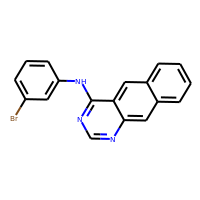
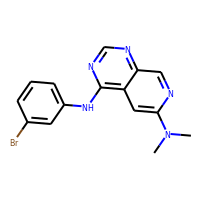
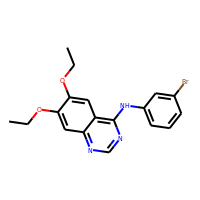
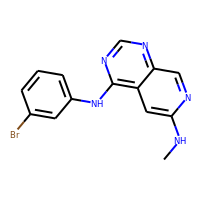
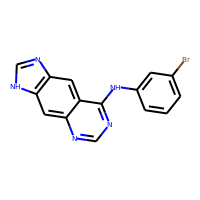

In [26]:
output_df.drop("smiles", axis=1).head()

#### Write output file
To use the data for the following talktorials, we save the data as csv file. Note that it is advisable to drop the molecule column (only contains an image of the molecules) when saving the data.

In [27]:
output_df.drop("ROMol", axis=1).to_csv("../data/T1/EGFR_compounds.csv")

## Discussion

In this tutorial, we collected all available bioactivity data for our target of interest from the ChEMBL database. We filtered the data set to only contain molecules with measured IC50 or pIC50 bioactivity values. 

Be aware that ChEMBL data originates from various sources. Compound data has been generated in different labs by different people all over the world. Therefore, we have to be cautious with the predictions we make using this dataset. It is always important to consider the source of the data and consistency of data production assays when interpreting the results and determining how much confidence we have in our predictions.

In the next tutorials we will filter our acquired data by the Lipinski rule of five and by unwanted substructures. Another important step would be to clean the data and remove duplicates. As this is not shown in any of our talktorials (yet), we would like to refer to the standardiser library ([github Francis Atkinson](https://github.com/flatkinson/standardiser)) or [MolVS](https://molvs.readthedocs.io/en/latest/) as possible tools for this task.

## Quiz

* We have downloaded in this talktorial molecules and bioactivity data from ChEMBL. What else is the ChEMBL database useful for?
* What is the difference between IC50 and EC50?
* What can we use the data extracted from ChEMBL for?